In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import shapely
import open3d as o3d
import geopandas as gpd
import folium
from pyproj import Proj, Transformer


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
#unzip a .7z file
import py7zr
path = "./data/LIDARHD_1-0_LAZ_PM-0914_6459-2021.7z"
with py7zr.SevenZipFile(path, mode='r') as z:
    z.extractall(path=".")

In [2]:
#open a laz file

path = "LIDARHD_1-0_LAZ_PM-0914_6459-2021\Semis_2021_0914_6459_LA93_IGN69.laz"
import laspy
lid = laspy.read(path)

In [4]:
p = lid.points

In [5]:
point_format = lid.point_format
list(point_format.dimension_names)

['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'synthetic',
 'key_point',
 'withheld',
 'scan_angle_rank',
 'user_data',
 'point_source_id',
 'gps_time']

In [3]:
coords = np.vstack((lid.x, lid.y, lid.z)).transpose()

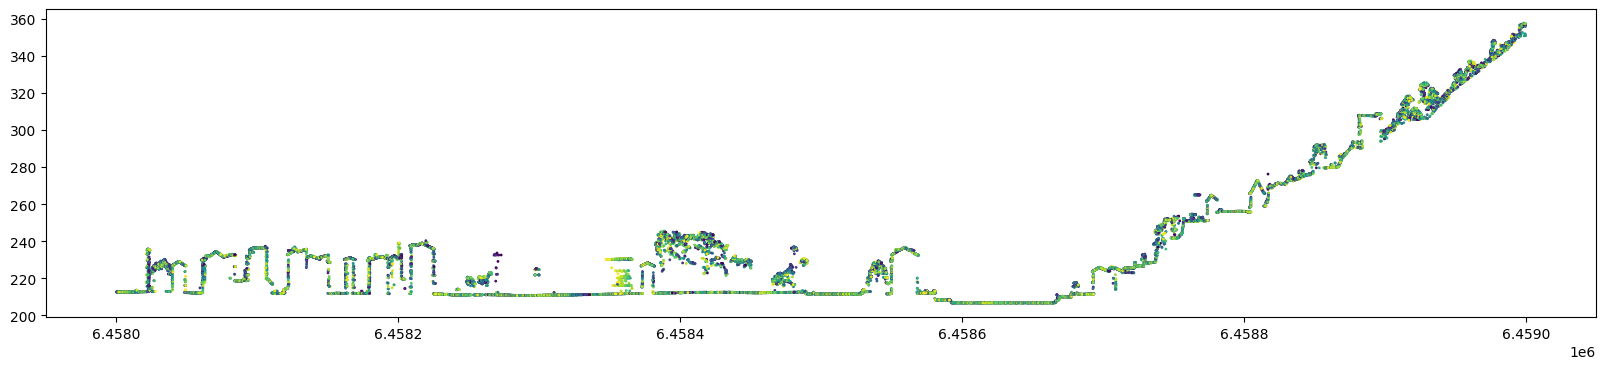

In [7]:
first_point = coords[0]

JDV = [914078.32, 6458524.26, first_point[2]]

distances = abs(coords[:,0] - JDV[0])
slice = coords[distances < np.quantile(distances, 0.001)]


plt.scatter(slice[:,1], slice[:,2], s=1, c=slice[:,0], cmap='viridis')
plt.gcf().set_size_inches(20, 4)

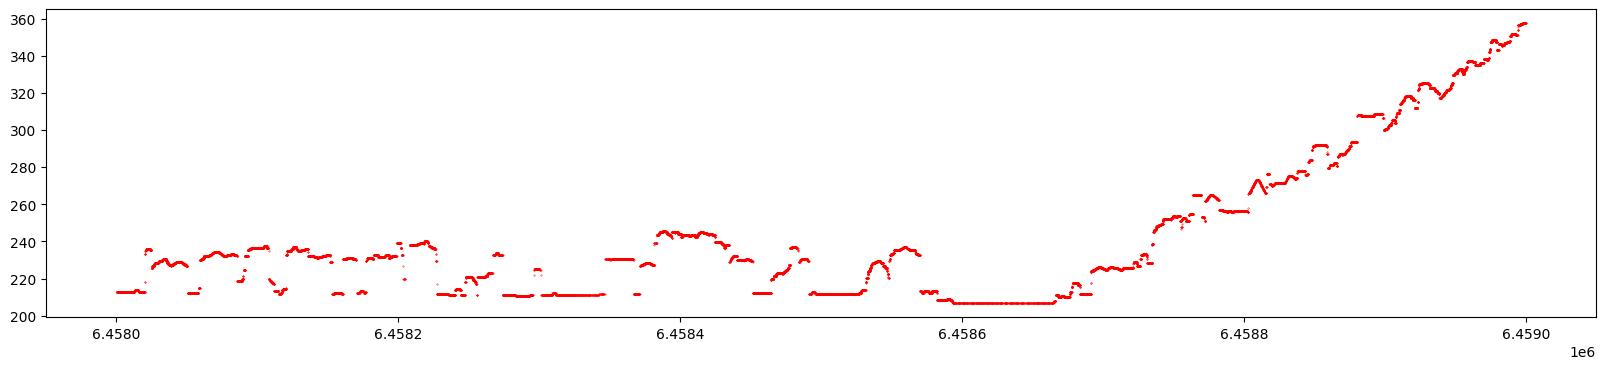

In [21]:
first_point = coords[0]

JDV = [914078.32, 6458524.26, first_point[2]]

distances = abs(coords[:,0] - JDV[0])
slice = coords[distances < np.quantile(distances, 0.001)]

slicey = list(set(slice[:,1]))
subslice = list(set([round(i, 1) for i in slicey]))
slicetop = [max(slice[abs(slice[:,1] - i) < 1][:,2]) for i in slicey]

#plt.scatter(slice[:,1], slice[:,2], s=1, c=slice[:,0], cmap='viridis')
plt.scatter(x = slicey, y = slicetop, s = .1, c = 'red')
plt.gcf().set_size_inches(20, 4)

In [18]:
print(len(slicey))
subslice = list(set([round(i, 1) for i in slicey]))

23458


8940

In [4]:
def gps_to_lamb(P):
    transformer = Transformer.from_crs("EPSG:2154", "EPSG:4326")
    x2,y2 = transformer.transform(P[0],P[1])
    return [x2,y2]

def lamb_to_gps(P):
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:2154")
    x2,y2 = transformer.transform(P[0],P[1])
    return [x2,y2]

def add_point(P, m):
    folium.Marker(location=gps_to_lamb(P), popup='JDV', icon=folium.Icon(color='red')).add_to(m)

C:\Users\Asus\AppData\Local\Temp\ipykernel_11836\1405057833.py:14: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2,y2 = transform(inProj,outProj,P[0],P[1])


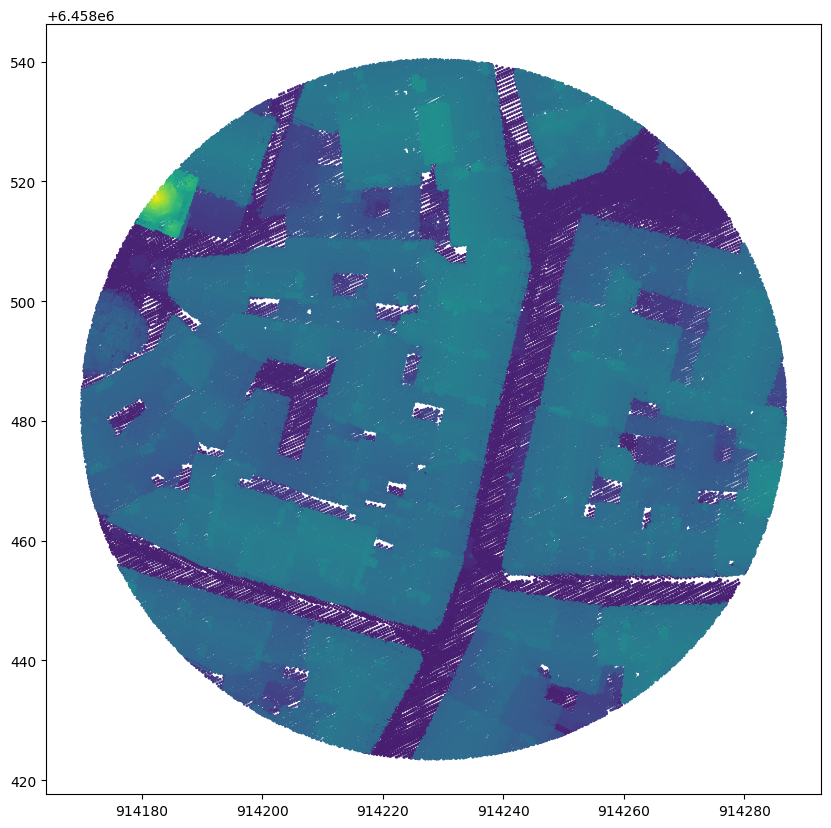

In [25]:
first_point = coords[0]
Maison = lamb_to_gps([45.19233596455863, 5.728565238809773])
# Maison.append(first_point[2])

distances = np.linalg.norm(coords[:,:2] - Maison, axis=1)

closest = distances < np.quantile(distances, 0.01)
closest_points = coords[closest]

plt.scatter(closest_points[:,0], closest_points[:,1], s=1, c=closest_points[:,2], cmap='viridis')
plt.gcf().set_size_inches(10, 10)

In [26]:
Maison

[914228.4530292188, 6458481.945984451]

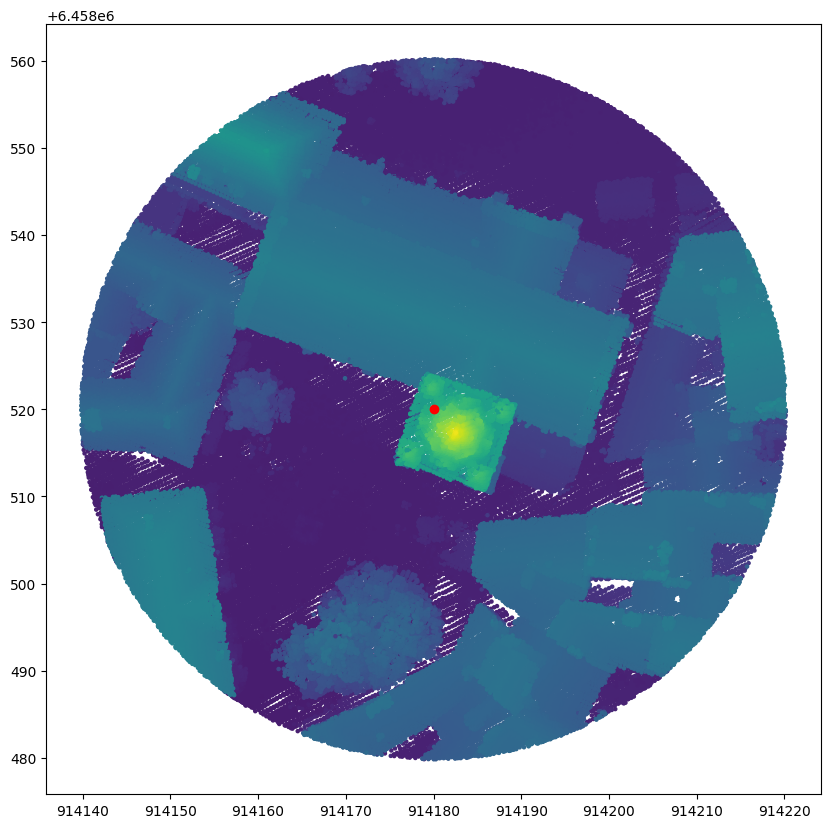

In [5]:
first_point = coords[0]
eglise = [914180, 6458520]
# Maison.append(first_point[2])

distances = np.linalg.norm(coords[:,:2] - eglise, axis=1)

closest = distances < np.quantile(distances, 0.005)
closest_points = coords[closest]

plt.scatter(closest_points[:,0], closest_points[:,1], s=5, c=closest_points[:,2], cmap='viridis')
plt.plot(eglise[0], eglise[1], 'ro')
plt.gcf().set_size_inches(10, 10)

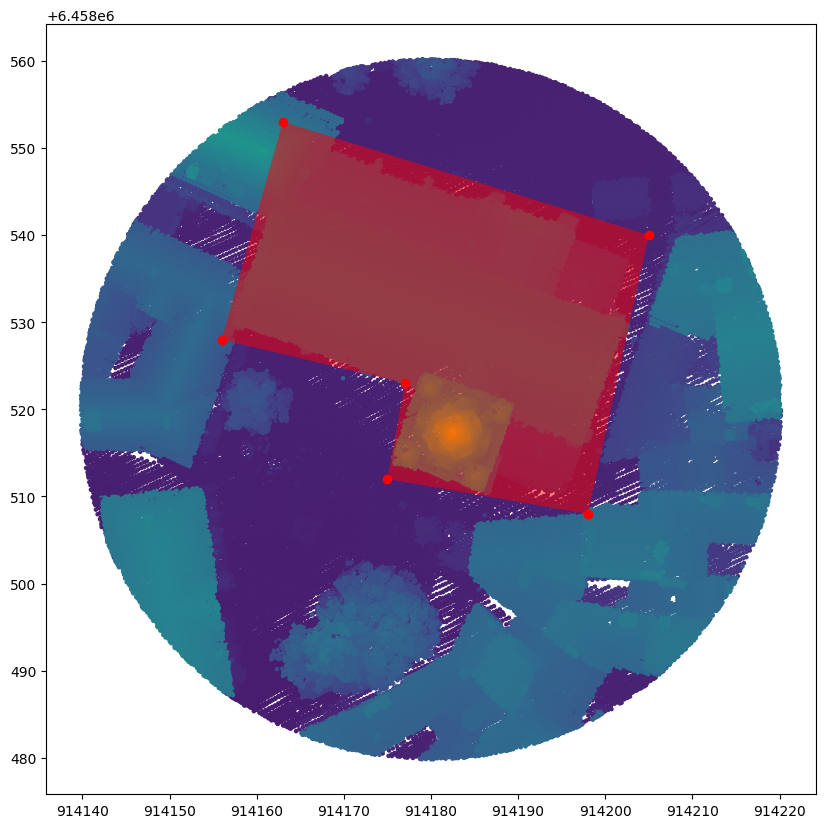

In [6]:
left = [156, 528]
top = [163, 553]
right = [205, 540]
bot = [198, 508]
tower = [175, 512]
corner = [177, 523]

shape_eglise = [left, top, right, bot, tower, corner]
shape_eglise = [[i[0]+914000, i[1] + 6458000] for i in shape_eglise] 
fig, ax = plt.subplots()
ax.scatter(closest_points[:,0], closest_points[:,1], s=5, c=closest_points[:,2], cmap='viridis')
for i in shape_eglise:
    ax.plot(i[0], i[1], 'ro')
    
egligon = shapely.geometry.Polygon(shape_eglise)
gpd.GeoSeries(egligon).plot(ax = ax, color = 'red', alpha = 0.5)
fig.set_size_inches(10, 10)

In [7]:

neighb = gpd.points_from_xy(closest_points[:,0], closest_points[:,1], z = closest_points[:,2], crs = 'epsg:2154')
len(neighb)

137464

In [8]:
church = gpd.GeoSeries(neighb[neighb.within(egligon)])
len(church)

40849

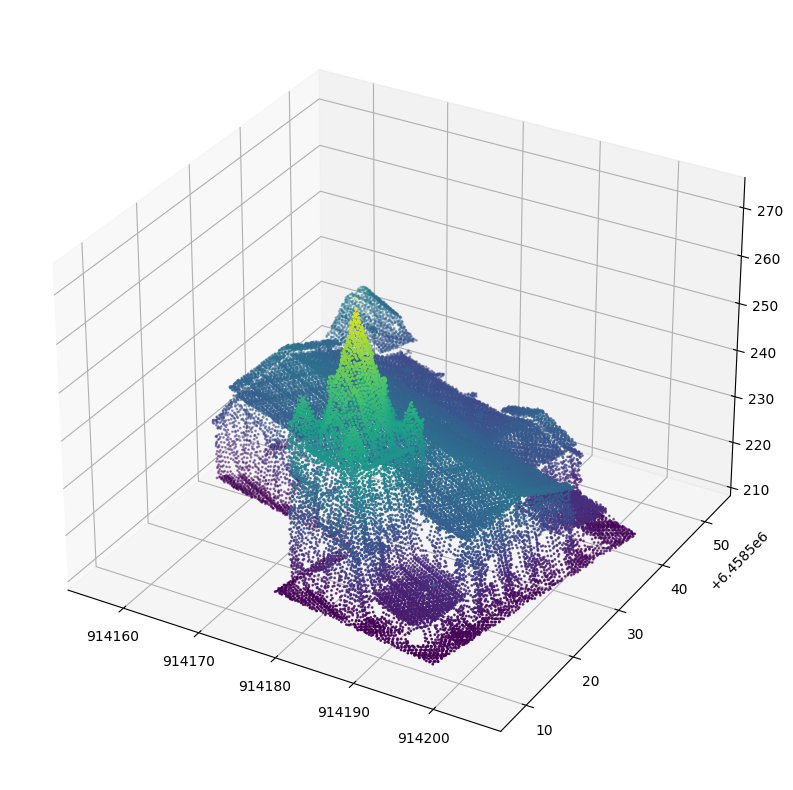

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(church.x, church.y, church.z, s=1, c=church.z, cmap='viridis')
fig.set_size_inches(10, 10)

In [10]:

churcharray = np.array([list(church.x), list(church.y), list(church.z)]).transpose()

In [11]:
pcd = o3d.geometry.PointCloud()

pcd.points = o3d.utility.Vector3dVector(churcharray)

pcd.estimate_normals()

In [22]:
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


In [32]:
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 4 * avg_dist

In [33]:
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))

In [34]:
mesh_smp = bpa_mesh.simplify_quadric_decimation(target_number_of_triangles=1000)
o3d.visualization.draw_geometries([mesh_smp])


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Descripteur non valide 
